In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if ".txt" in filename:
            print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/home-data/Houses Dataset/HousesInfo.txt


## Import Statement

In [2]:
import pandas as pd
import numpy as np
import os 
import matplotlib.pyplot as plt

from collections.abc import Sequence
from sklearn import preprocessing
from sklearn.model_selection import train_test_split
from sklearn import metrics
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Activation, Dropout, Conv2D,MaxPooling2D, Flatten
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.callbacks import ModelCheckpoint

In [3]:
import seaborn as sns
import csv
import numpy as np
%matplotlib inline

import cv2
import glob
from IPython.display import Image

In [4]:
import tensorflow as tf
tf.test.gpu_device_name()

'/device:GPU:0'

In [5]:
def encode_text_dummy(df, name):
    dummies = pd.get_dummies(df[name])
    for x in dummies.columns:
        dummy_name = "{}-{}".format(name, x)
        df[dummy_name] = dummies[x]
    df.drop(name, axis=1, inplace=True)
    
def encode_numeric_zscore(df, name, mean=None, sd=None):
    if mean is None:
        mean = df[name].mean()

    if sd is None:
        sd = df[name].std()

    df[name] = (df[name] - mean) / sd

def missing_median(df, name):
    med = df[name].median()
    df[name] = df[name].fillna(med)
    
def to_xy(df, target):
    result = []
    for x in df.columns:
        if x != target:
            result.append(x)
    # find out the type of the target column.
    target_type = df[target].dtypes
    target_type = target_type[0] if isinstance(target_type, Sequence) else target_type
    # Encode to int for classification, float otherwise. TensorFlow likes 32 bits.
    if target_type in (np.int64, np.int32):
        # Classification
        dummies = pd.get_dummies(df[target])
        return df[result].values.astype(np.float32), dummies.values.astype(np.float32)
    else:
        # Regression
        return df[result].values.astype(np.float32), df[target].values.astype(np.float32)
    
def remove_outliers(df, name, sd):
    drop_rows = df.index[(np.abs(df[name] - df[name].mean()) >= (sd * df[name].std()))]
    df.drop(drop_rows, axis=0, inplace=True)

def encode_numeric_range(df, name, normalized_low=-1, normalized_high=1,
                         data_low=None, data_high=None):
    if data_low is None:
        data_low = min(df[name])
        data_high = max(df[name])

    df[name] = ((df[name] - data_low) / (data_high - data_low)) \
               * (normalized_high - normalized_low) + normalized_low

def chart_regression(pred,y,sort=True):
    t = pd.DataFrame({'pred' : pred, 'y' : y.flatten()})
    if sort:
        t.sort_values(by=['y'],inplace=True)
    a = plt.plot(t['y'].tolist(),label='expected')
    b = plt.plot(t['pred'].tolist(),label='prediction')
    plt.ylabel('output')
    plt.legend()
    plt.show()

## Data Preprocessing

### Import Data

In [6]:
filename_read = '/kaggle/input/home-data/Houses Dataset/HousesInfo.txt' 
# filename_read = './Houses Dataset/HousesInfo.txt'

In [7]:
cols=["Bedrooms","Bathrooms","area","zipcode","price"]
df = pd.read_csv(filename_read , sep=" ", header=None , names=cols)

In [8]:
df.head()

Bedrooms  Bathrooms  area  zipcode   price
0         4        4.0  4053    85255  869500
1         4        3.0  3343    36372  865200
2         3        4.0  3923    85266  889000
3         5        5.0  4022    85262  910000
4         3        4.0  4116    85266  971226

In [9]:
df.shape

(535, 5)

In [10]:
# Keep the house prices between 300k and 900k (all others maybe considered outliers)
# Show distribution

### Handle Images dataset

In [11]:
filepath = "/kaggle/input/home-data/Houses Dataset/"
# filepath = './Houses Dataset/'

In [12]:
## Bathroom.jpg
new_images=[]
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_bathroom.jpg"):
        if os.path.isfile(path):
            new_images.append(path) 

In [13]:
new_images[:5]

['/kaggle/input/home-data/Houses Dataset/1_bathroom.jpg',
 '/kaggle/input/home-data/Houses Dataset/2_bathroom.jpg',
 '/kaggle/input/home-data/Houses Dataset/3_bathroom.jpg',
 '/kaggle/input/home-data/Houses Dataset/4_bathroom.jpg',
 '/kaggle/input/home-data/Houses Dataset/5_bathroom.jpg']

In [14]:
img= pd.DataFrame(new_images,columns = ['bathroom_img'])

In [15]:
## bedroom images
bedroom_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_bedroom.jpg"):
        if os.path.isfile(path):
            bedroom_images.append(path) 

In [16]:
img['bedroom_img']=bedroom_images

In [17]:
frontal_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_frontal.jpg"):
        if os.path.isfile(path):
            frontal_images.append(path) 

In [18]:
img['frontal_img']=frontal_images

In [19]:
kitchen_images = []
for number in range(1, df.shape[0] + 1):
    for path in glob.glob(filepath + str(number) + "_kitchen.jpg"):
        if os.path.isfile(path):
            kitchen_images.append(path) 

In [20]:
img['kitchen_img']=kitchen_images

In [21]:
img.head()

bathroom_img  \
0  /kaggle/input/home-data/Houses Dataset/1_bathr...   
1  /kaggle/input/home-data/Houses Dataset/2_bathr...   
2  /kaggle/input/home-data/Houses Dataset/3_bathr...   
3  /kaggle/input/home-data/Houses Dataset/4_bathr...   
4  /kaggle/input/home-data/Houses Dataset/5_bathr...   

                                         bedroom_img  \
0  /kaggle/input/home-data/Houses Dataset/1_bedro...   
1  /kaggle/input/home-data/Houses Dataset/2_bedro...   
2  /kaggle/input/home-data/Houses Dataset/3_bedro...   
3  /kaggle/input/home-data/Houses Dataset/4_bedro...   
4  /kaggle/input/home-data/Houses Dataset/5_bedro...   

                                         frontal_img  \
0  /kaggle/input/home-data/Houses Dataset/1_front...   
1  /kaggle/input/home-data/Houses Dataset/2_front...   
2  /kaggle/input/home-data/Houses Dataset/3_front...   
3  /kaggle/input/home-data/Houses Dataset/4_front...   
4  /kaggle/input/home-data/Houses Dataset/5_front...   

                                         kitchen_img  
0  /kaggle/input/home-data/Houses Dataset/1_kitch...  
1  /kaggle/input/home-data/Houses Dataset/2_kitch...  
2  /kaggle/input/home-data/Houses Dataset/3_kitch...  
3  /kaggle/input/home-data/Houses Dataset/4_kitch...  
4  /kaggle/input/home-data/Houses Dataset/5_kitch...

### Describe price distribution and handle outliers

In [22]:
price_summary = df['price'].describe()

price_summary

count    5.350000e+02
mean     5.893628e+05
std      5.090261e+05
min      2.200000e+04
25%      2.492000e+05
50%      5.290000e+05
75%      7.285000e+05
max      5.858000e+06
Name: price, dtype: float64

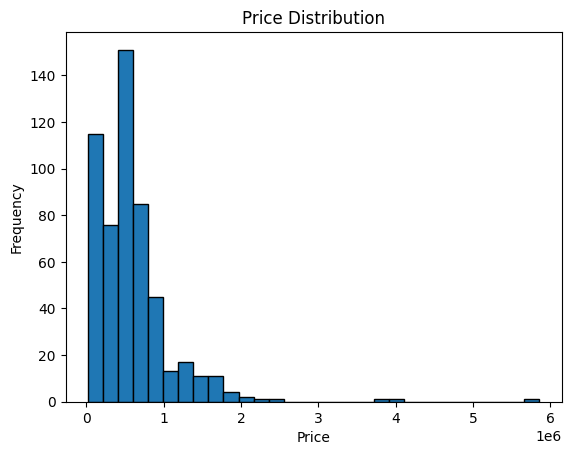

In [23]:
# Print out the spread of prices using matplotlib
# Assuming df['prices'] contains your price data
plt.hist(df['price'], bins=30, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

In [24]:
# Remove values that are outliers
# df.iloc[row, col]
outliers = []
for i in range(0, len(df)):
    if df.iloc[i, :].price < 300000 or df.iloc[i, :].price > 900000: 
        outliers.append(i)
        # print("Outliers:", df.loc[outliers, 'price'])

#         print(i, df.iloc[i, :].price)

print("Outliers", len(outliers))
print("Remaining", 535 - len(outliers))

print(outliers)

Outliers 227
Remaining 308
[3, 4, 5, 7, 8, 9, 11, 18, 19, 20, 21, 23, 24, 25, 26, 28, 29, 31, 33, 34, 35, 36, 38, 50, 53, 58, 59, 60, 62, 63, 64, 65, 66, 67, 68, 70, 71, 72, 74, 75, 76, 77, 78, 79, 86, 90, 92, 94, 96, 102, 109, 111, 112, 115, 125, 128, 130, 132, 133, 136, 143, 146, 148, 149, 150, 151, 152, 153, 154, 155, 156, 157, 158, 160, 161, 164, 168, 170, 172, 184, 185, 186, 190, 192, 202, 203, 207, 209, 214, 215, 216, 218, 219, 220, 223, 224, 226, 252, 255, 256, 257, 260, 261, 263, 266, 268, 270, 285, 286, 287, 288, 289, 290, 291, 292, 293, 318, 320, 321, 330, 331, 332, 333, 334, 335, 336, 337, 338, 339, 340, 341, 342, 343, 344, 345, 346, 347, 348, 349, 350, 351, 352, 353, 354, 355, 356, 357, 358, 359, 360, 361, 362, 363, 364, 365, 366, 367, 368, 369, 370, 372, 373, 374, 375, 376, 377, 378, 379, 380, 381, 382, 383, 384, 385, 386, 387, 388, 389, 390, 391, 392, 393, 394, 395, 396, 397, 398, 399, 400, 401, 402, 403, 404, 405, 406, 407, 408, 409, 410, 411, 412, 413, 414, 415, 416, 41

In [25]:
data = df[~df.index.isin(outliers)]

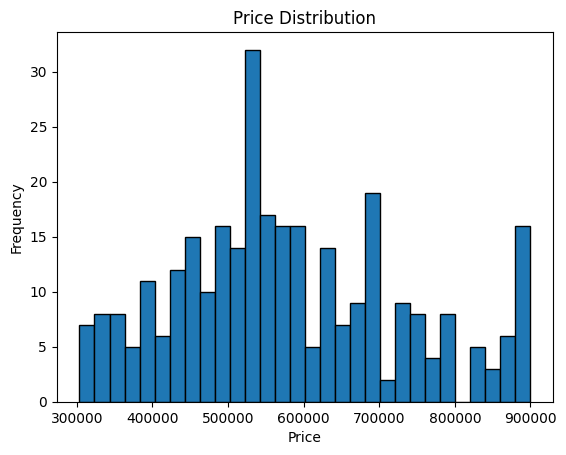

In [26]:
# Print out the spread of prices using matplotlib
# Assuming df['prices'] contains your price data
plt.hist(data['price'], bins=30, edgecolor='black')
plt.title('Price Distribution')
plt.xlabel('Price')
plt.ylabel('Frequency')
plt.show()

### Merge bathroom, bedroom, frontal, and kitchen into one image

In [27]:
images_output=[]
img_df = img
for row_index,row in img.iterrows():
    # Check if the row_index is in the outliers to do this do the outliers first
    if row_index in outliers: 
      img_df = img_df[img_df.index != row_index] # Remove outlier
      # print(img_df.shape)
      continue

    inputImages=[]
    outputImage = np.zeros((128, 128, 3), dtype="uint8")
    image_temp1 = cv2.imread(row.bathroom_img)
    image1 = cv2.resize(image_temp1, (64 , 64))
            
    image_temp2 = cv2.imread(row.bedroom_img)
    image2 = cv2.resize(image_temp2, (64 , 64))
            
    image_temp3 = cv2.imread(row.frontal_img)
    image3 = cv2.resize(image_temp3, (64 , 64))
            
    image_temp4 = cv2.imread(row.kitchen_img)
    image4 = cv2.resize(image_temp4, (64 , 64))
              
    inputImages.append(image1)
    inputImages.append(image2)
    inputImages.append(image3)
    inputImages.append(image4)
            
    outputImage[0:64, 0:64] = inputImages[0]
    outputImage[0:64, 64:128] = inputImages[1]
    outputImage[64:128, 64:128] = inputImages[2]
    outputImage[64:128, 0:64] = inputImages[3]
            
    images_output.append(outputImage)  

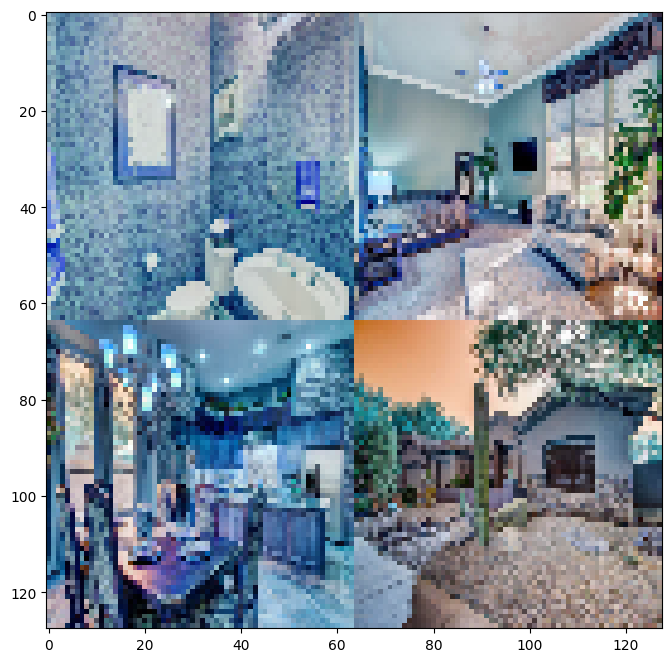

In [28]:
plt.figure(figsize=(8,8))
plt.imshow(images_output[0], interpolation='nearest')
plt.show()

### Check if same outliers are removed from both img and textual tables

In [29]:
# All the images match
value = data[img_df.index == data.index]
value.shape

(308, 5)

### Normalize/One Hot Encode Textual Data and Normalize image data

In [30]:
# One hot encode zip code & area
# encode_text_dummy(data, 'zipcode')
# encode_text_dummy(data, 'area')

data_formatted = pd.get_dummies(data, columns=['zipcode'])

In [31]:
data_formatted.head()

Bedrooms  Bathrooms  area   price  zipcode_36372  zipcode_60002  \
0          4        4.0  4053  869500          False          False   
1          4        3.0  3343  865200           True          False   
2          3        4.0  3923  889000          False          False   
6          3        4.0  2544  799000          False          False   
10         5        5.0  4829  519200          False          False   

    zipcode_62025  zipcode_62249  zipcode_81418  zipcode_81524  ...  \
0           False          False          False          False  ...   
1           False          False          False          False  ...   
2           False          False          False          False  ...   
6           False          False          False          False  ...   
10          False          False          False          False  ...   

    zipcode_93314  zipcode_93446  zipcode_93510  zipcode_94501  zipcode_94531  \
0           False          False          False          False          False   
1           False          False          False          False          False   
2           False          False          False          False          False   
6           False          False          False          False          False   
10          False          False          False          False          False   

    zipcode_94565  zipcode_94568  zipcode_95220  zipcode_96019  zipcode_98021  
0           False          False          False          False          False  
1           False          False          False          False          False  
2           False          False          False          False          False  
6           False          False          False          False          False  
10          False          False          False          False          False  

[5 rows x 36 columns]

In [32]:
# Normalize bedrooms & bathrooms & area
encode_numeric_zscore(data_formatted, 'Bedrooms')
encode_numeric_zscore(data_formatted, 'Bathrooms')
encode_numeric_zscore(data_formatted, 'area')

In [33]:
print(data_formatted['price'].dtype)

data_formatted['price'] = data_formatted['price'].astype("float32")

print(data_formatted['price'].dtype)

int64
float32


In [34]:
# data_formatted['price'] = data_formatted['price']

In [35]:
# normalize image data
img_output_df = np.array(images_output).astype('float32')
img_output_df /= 255.0

## to_xy and Test/Train Split

In [36]:
# use to_xy to split the tabular data into x and y
x, y = to_xy(data_formatted, 'price')
print(x.shape, y.shape)

(308, 35) (308,)


In [37]:
y[:5]

array([869500., 865200., 889000., 799000., 519200.], dtype=float32)

In [38]:
x_train, x_test, y_train, y_test= train_test_split(x, y, test_size=.20, random_state = 42)

In [39]:
print("Train Sizes :", x_train.shape, y_train.shape)
print("Test Sizes :", x_test.shape, y_test.shape)

Train Sizes : (246, 35) (246,)
Test Sizes : (62, 35) (62,)


In [40]:
x_train_img, x_test_img = train_test_split(img_output_df, test_size=.20,
                                          random_state=42)

In [41]:
print("Train Sizes :", x_train_img.shape)
print("Test Sizes :", x_test_img.shape)

Train Sizes : (246, 128, 128, 3)
Test Sizes : (62, 128, 128, 3)


## Pre Model Training Check

In [42]:
print(f"x_train shape: ", x_train.shape)
print(f"x_train_img shape: ", x_train_img.shape)
print(f"x_test shape: ", x_test.shape)
print(f"x_test_img shape: ", x_test_img.shape)
print()

print(f"y_train shape: ", y_train.shape)
print(f"y_test shape: ",y_test.shape)

x_train shape:  (246, 35)
x_train_img shape:  (246, 128, 128, 3)
x_test shape:  (62, 35)
x_test_img shape:  (62, 128, 128, 3)

y_train shape:  (246,)
y_test shape:  (62,)


In [43]:
from keras.utils import plot_model
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten
from tensorflow.keras.layers import Input, Dense
from tensorflow.keras.models import Model, Sequential
from tensorflow.keras.layers import concatenate
from keras.optimizers import Adam, SGD

## Base Model : Only Textual Input

In [44]:
filepath = './dnn/best_weights-base.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999,epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.007, momentum=0.9, nesterov=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-5, patience=5,verbose=1, mode='auto')

model = Sequential()
model.add(Dense(4096, activation='relu'))
model.add(Dense(3000, activation='relu'))
model.add(Dropout(0.3))

model.add(Dense(2048, activation='relu'))
model.add(Dense(1024, activation='relu'))
model.add(Dense(516, activation='relu'))
model.add(Dense(1))

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit(x_train, y_train, 
          validation_data=(x_test, y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=200)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred_base = model.predict(x_test)
score_base = np.sqrt(metrics.mean_squared_error(pred_base,y_test))
print("Score (RMSE): {}".format(score_base))

Epoch 1/200


I0000 00:00:1729645961.509953     101 service.cc:145] XLA service 0x7acb28006fe0 initialized for platform CUDA (this does not guarantee that XLA will be used). Devices:
I0000 00:00:1729645961.509998     101 service.cc:153]   StreamExecutor device (0): Tesla T4, Compute Capability 7.5
I0000 00:00:1729645961.510003     101 service.cc:153]   StreamExecutor device (1): Tesla T4, Compute Capability 7.5
I0000 00:00:1729645964.844040     101 device_compiler.h:188] Compiled cluster using XLA!  This line is logged at most once for the lifetime of the process.


8/8 - 16s - 2s/step - loss: 205308133376.0000 - val_loss: 71286177792.0000
Epoch 2/200
8/8 - 1s - 153ms/step - loss: 39483125760.0000 - val_loss: 42175311872.0000
Epoch 3/200
8/8 - 1s - 144ms/step - loss: 41181831168.0000 - val_loss: 32654471168.0000
Epoch 4/200
8/8 - 0s - 13ms/step - loss: 31822434304.0000 - val_loss: 44866752512.0000
Epoch 5/200
8/8 - 1s - 148ms/step - loss: 23962263552.0000 - val_loss: 22959218688.0000
Epoch 6/200
8/8 - 4s - 487ms/step - loss: 20260399104.0000 - val_loss: 19696099328.0000
Epoch 7/200
8/8 - 0s - 13ms/step - loss: 20689192960.0000 - val_loss: 31720919040.0000
Epoch 8/200
8/8 - 0s - 12ms/step - loss: 20090097664.0000 - val_loss: 22250913792.0000
Epoch 9/200
8/8 - 0s - 12ms/step - loss: 17019675648.0000 - val_loss: 27193542656.0000
Epoch 10/200
8/8 - 1s - 152ms/step - loss: 13604897792.0000 - val_loss: 19151042560.0000
Epoch 11/200
8/8 - 2s - 259ms/step - loss: 10825491456.0000 - val_loss: 18894815232.0000
Epoch 12/200
8/8 - 0s - 13ms/step - loss: 10533

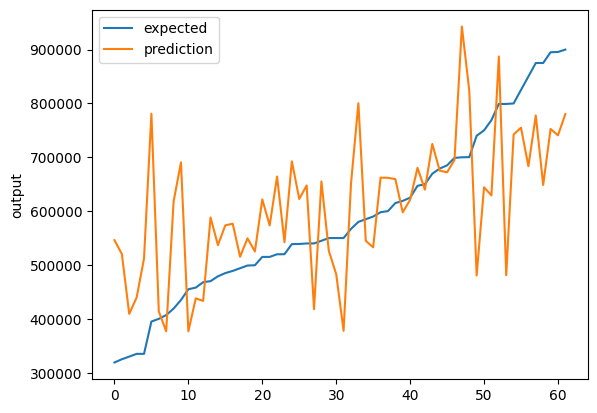

In [45]:
chart_regression(pred_base.flatten(),y_test)

## Both Input : Model #1

In [46]:
filepath = './dnn/best_weights1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)


monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose=1, mode='auto')

# first image input model
visible1 = Input(shape=(128, 128, 3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)
conv12 = Conv2D(64, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)
# conv13 = Conv2D(64, kernel_size=4, activation='relu')(pool12)
# pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)
flat1 = Flatten()(pool12)

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(128, activation='relu')(visible2)
dense2 = Dense(64, activation='relu')(dense1)
dense3 = Dense(32, activation='relu')(dense2)

merge = concatenate([flat1, dense3])

# hidden1 = Dense(32, activation='relu')(merge)
# hidden2 = Dense(8, activation='relu')(hidden1)
# output = Dense(1)(hidden2)

output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred = model.predict([x_test_img, x_test])
score = np.sqrt(metrics.mean_squared_error(pred,y_test))
print("Score (RMSE): {}".format(score))

Epoch 1/100
8/8 - 8s - 1s/step - loss: 355371155456.0000 - val_loss: 359970963456.0000
Epoch 2/100
8/8 - 0s - 27ms/step - loss: 316526166016.0000 - val_loss: 258217508864.0000
Epoch 3/100
8/8 - 0s - 26ms/step - loss: 157490135040.0000 - val_loss: 40245022720.0000
Epoch 4/100
8/8 - 0s - 22ms/step - loss: 43660349440.0000 - val_loss: 59467612160.0000
Epoch 5/100
8/8 - 0s - 28ms/step - loss: 35723415552.0000 - val_loss: 35813642240.0000
Epoch 6/100
8/8 - 0s - 27ms/step - loss: 35536146432.0000 - val_loss: 32045844480.0000
Epoch 7/100
8/8 - 0s - 31ms/step - loss: 28900614144.0000 - val_loss: 32354478080.0000
Epoch 8/100
8/8 - 0s - 42ms/step - loss: 28354785280.0000 - val_loss: 29548832768.0000
Epoch 9/100
8/8 - 0s - 25ms/step - loss: 27668094976.0000 - val_loss: 29022355456.0000
Epoch 10/100
8/8 - 0s - 20ms/step - loss: 27189727232.0000 - val_loss: 29022423040.0000
Epoch 11/100
8/8 - 0s - 20ms/step - loss: 26892947456.0000 - val_loss: 29162377216.0000
Epoch 12/100
8/8 - 0s - 25ms/step - lo

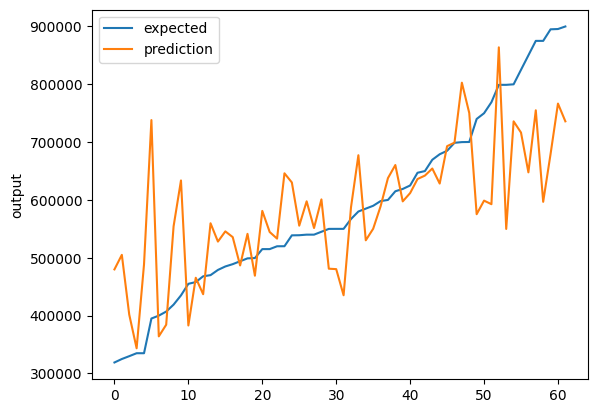

In [47]:
chart_regression(pred.flatten(),y_test)

## Both inputs : Model #2

In [48]:
filepath = './dnn/best_weights1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Maybe go between 1e-3 and 1e-2  = .5e-3
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose=1, mode='auto')

# first image input model
visible1 = Input(shape=(128, 128, 3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)

conv12 = Conv2D(64, kernel_size=4, activation='relu')(pool11)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

conv13 = Conv2D(128, kernel_size=4, activation='relu')(pool12)
pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)

conv14 = Conv2D(256, kernel_size=4, activation='relu')(pool13)
pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)

# pool14 = Dropout(0.5)(pool14)
flat1 = Flatten()(pool14)

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(2048, activation='relu')(visible2)
# dense1 = Dropout(0.3)(dense1)
dense2 = Dense(1024, activation='relu')(dense1)
dense3 = Dense(516, activation='relu')(dense2)

merge = concatenate([flat1, dense3])

hidden1 = Dense(1024, activation='relu')(merge)
hidden2 = Dense(512, activation='relu')(hidden1)
hidden2 = Dense(256, activation='relu')(hidden1)
output = Dense(1)(hidden2)

# output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred2 = model.predict([x_test_img, x_test])
score2 = np.sqrt(metrics.mean_squared_error(pred2,y_test))
print("Score (RMSE): {}".format(score2))

Epoch 1/100
8/8 - 15s - 2s/step - loss: 389828804608.0000 - val_loss: 370462785536.0000
Epoch 2/100
8/8 - 1s - 97ms/step - loss: 356003119104.0000 - val_loss: 361044738048.0000
Epoch 3/100
8/8 - 1s - 94ms/step - loss: 247356686336.0000 - val_loss: 74892238848.0000
Epoch 4/100
8/8 - 1s - 93ms/step - loss: 48796364800.0000 - val_loss: 43721646080.0000
Epoch 5/100
8/8 - 1s - 92ms/step - loss: 33067431936.0000 - val_loss: 28155848704.0000
Epoch 6/100
8/8 - 0s - 27ms/step - loss: 27799035904.0000 - val_loss: 32036517888.0000
Epoch 7/100
8/8 - 0s - 27ms/step - loss: 27639185408.0000 - val_loss: 29596291072.0000
Epoch 8/100
8/8 - 0s - 27ms/step - loss: 22858250240.0000 - val_loss: 28584753152.0000
Epoch 9/100
8/8 - 1s - 90ms/step - loss: 20207935488.0000 - val_loss: 18616401920.0000
Epoch 10/100
8/8 - 3s - 374ms/step - loss: 14237435904.0000 - val_loss: 16916883456.0000
Epoch 11/100
8/8 - 1s - 97ms/step - loss: 13455213568.0000 - val_loss: 16301957120.0000
Epoch 12/100
8/8 - 1s - 88ms/step - 

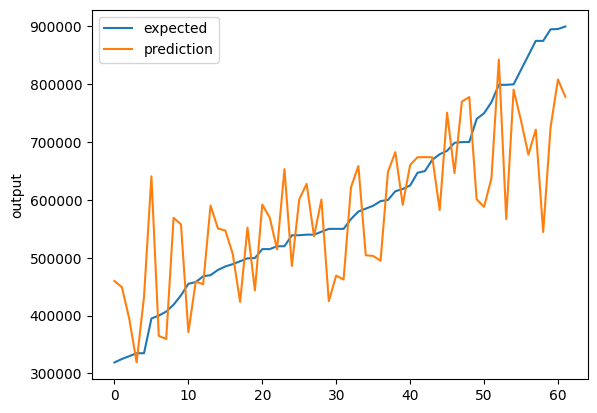

In [49]:
chart_regression(pred2.flatten(),y_test)

## Both Inputs : Model # 3

In [51]:
filepath = './dnn/best_weights3.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.01, momentum=0.9, nesterov=True)

# Maybe go between 1e-3 and 1e-2  = .5e-3
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5,verbose=1, mode='auto')

# first image input model
visible1 = Input(shape=(128, 128, 3))
conv11 = Conv2D(32, kernel_size=4, activation='relu')(visible1)
conv11 = Conv2D(32, kernel_size=4, activation='relu')(conv11)
pool11 = MaxPooling2D(pool_size=(2, 2))(conv11)

conv12 = Conv2D(64, kernel_size=4, activation='relu')(pool11)
conv12 = Conv2D(64, kernel_size=4, activation='relu')(conv12)
pool12 = MaxPooling2D(pool_size=(2, 2))(conv12)

conv13 = Conv2D(128, kernel_size=4, activation='relu')(pool12)
conv13 = Conv2D(256, kernel_size=4, activation='relu')(conv12)
pool13 = Dropout(0.5)(conv13) # Why does this work?
pool13 = MaxPooling2D(pool_size=(2, 2))(conv13)

conv14 = Conv2D(512, kernel_size=4, activation='relu')(pool13)
pool14 = MaxPooling2D(pool_size=(2, 2))(conv14)

# pool14 = Dropout(0.5)(pool14)
flat1 = Flatten()(pool14)

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(2048, activation='relu')(visible2)
dense1 = Dropout(0.3)(dense1)
dense2 = Dense(1024, activation='relu')(dense1)
dense2 = Dropout(0.5)(dense2)
dense3 = Dense(516, activation='relu')(dense2)

merge = concatenate([flat1, dense3])

hidden1 = Dense(1024, activation='relu')(merge)
hidden2 = Dense(512, activation='relu')(hidden1)
hidden3 = Dense(256, activation='relu')(hidden2)
output = Dense(1)(hidden3)

# output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
# plot_model(model, show_shapes=True)
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training model 1 finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred3 = model.predict([x_test_img, x_test])
score3 = np.sqrt(metrics.mean_squared_error(pred3,y_test))
print("Score (RMSE): {}".format(score3))


Epoch 1/100
8/8 - 37s - 5s/step - loss: 288773341184.0000 - val_loss: 3572049379328.0000
Epoch 2/100
8/8 - 4s - 561ms/step - loss: 717000146944.0000 - val_loss: 370902532096.0000
Epoch 3/100
8/8 - 7s - 854ms/step - loss: 356601331712.0000 - val_loss: 366871117824.0000
Epoch 4/100
8/8 - 5s - 682ms/step - loss: 250228490240.0000 - val_loss: 80654065664.0000
Epoch 5/100
8/8 - 7s - 861ms/step - loss: 47811641344.0000 - val_loss: 30857465856.0000
Epoch 6/100
8/8 - 5s - 682ms/step - loss: 29340442624.0000 - val_loss: 27620294656.0000
Epoch 7/100
8/8 - 7s - 851ms/step - loss: 21733648384.0000 - val_loss: 22747494400.0000
Epoch 8/100
8/8 - 1s - 116ms/step - loss: 21051240448.0000 - val_loss: 22858186752.0000
Epoch 9/100
8/8 - 4s - 548ms/step - loss: 18788083712.0000 - val_loss: 20866897920.0000
Epoch 10/100
8/8 - 1s - 112ms/step - loss: 16698616832.0000 - val_loss: 23065987072.0000
Epoch 11/100
8/8 - 1s - 105ms/step - loss: 16494222336.0000 - val_loss: 22608250880.0000
Epoch 12/100
8/8 - 4s - 

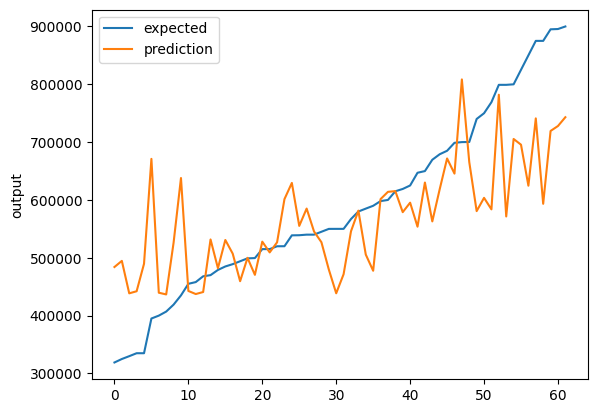

In [54]:
chart_regression(pred3.flatten(),y_test)

## Transfer Learning : VGG16 #1

In [77]:
# Transfer learning
from keras.applications.vgg16 import VGG16

filepath = './dnn/best_weights-vgg1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.001, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# Transfer - Learning : VGG 16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 
  
# Freeze the weights
for layer in vgg.layers:
    layer.trainable = False

conv_layer = Conv2D(128, kernel_size=3, activation='relu')(vgg.output)  
max_pool = MaxPooling2D(pool_size=(2, 2))(conv_layer)
vgg_out = Flatten()(max_pool)
visible1 = vgg.input

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(2048, activation='relu')(visible2)
dense2 = Dense(1024, activation='relu')(dense1)
dense3 = Dense(512, activation='relu')(dense2)

merge = concatenate([vgg_out, dense3])

output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred_vgg1 = model.predict([x_test_img, x_test])
score_vgg1 = np.sqrt(metrics.mean_squared_error(pred_vgg1,y_test))
print("Score (RMSE): {}".format(score_vgg1))

Epoch 1/100
8/8 - 6s - 764ms/step - loss: 357109497856.0000 - val_loss: 370915442688.0000
Epoch 2/100
8/8 - 1s - 113ms/step - loss: 356988944384.0000 - val_loss: 370658705408.0000
Epoch 3/100
8/8 - 1s - 105ms/step - loss: 356540809216.0000 - val_loss: 369840062464.0000
Epoch 4/100
8/8 - 1s - 105ms/step - loss: 355244867584.0000 - val_loss: 367667609600.0000
Epoch 5/100
8/8 - 1s - 109ms/step - loss: 352157007872.0000 - val_loss: 362729996288.0000
Epoch 6/100
8/8 - 1s - 106ms/step - loss: 345199706112.0000 - val_loss: 352804208640.0000
Epoch 7/100
8/8 - 2s - 263ms/step - loss: 331964973056.0000 - val_loss: 334684979200.0000
Epoch 8/100
8/8 - 1s - 105ms/step - loss: 309405581312.0000 - val_loss: 304690692096.0000
Epoch 9/100
8/8 - 1s - 106ms/step - loss: 272897736704.0000 - val_loss: 259861118976.0000
Epoch 10/100
8/8 - 1s - 105ms/step - loss: 221373038592.0000 - val_loss: 200332050432.0000
Epoch 11/100
8/8 - 2s - 299ms/step - loss: 155859075072.0000 - val_loss: 135237328896.0000
Epoch 12

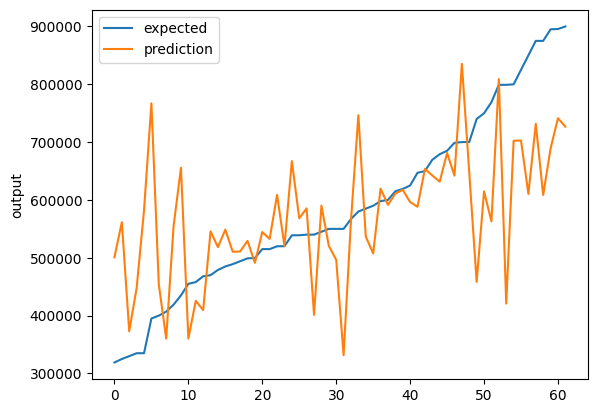

In [78]:
chart_regression(pred_vgg1.flatten(),y_test)

## Transfer Learning : VGG16 #2 (trainable = true)

In [79]:
# Transfer learning
from keras.applications.vgg16 import VGG16

filepath = './dnn/best_weights-vgg2.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.005, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=5, verbose=1, mode='auto')

# Transfer - Learning : VGG 16
vgg = VGG16(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 
  
# Freeze the weights
for layer in vgg.layers:
    layer.trainable = True

conv_layer = Conv2D(128, kernel_size=3, activation='relu')(vgg.output)  
max_pool = MaxPooling2D(pool_size=(2, 2))(conv_layer)
vgg_out = Flatten()(max_pool)
visible1 = vgg.input

# Tabular data input model 
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(2048, activation='relu')(visible2)
dense2 = Dense(1024, activation='relu')(dense1)
dense3 = Dense(512, activation='relu')(dense2)

merge = concatenate([vgg_out, dense3])

# hidden1 = Dense(512, activation='relu')(merge)
# hidden2 = Dense(256, activation='relu')(hidden1)
# output = Dense(1)(hidden2)

output = Dense(1)(merge)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer],verbose=2,epochs=100)
  
print('Training finished...Loading the best model')
print()
# model.load_weights(filepath) # load weights from best model

pred_vgg2 = model.predict([x_test_img, x_test])
score_vgg2 = np.sqrt(metrics.mean_squared_error(pred_vgg2,y_test))
print("Score (RMSE): {}".format(score_vgg2))

Epoch 1/100
8/8 - 11s - 1s/step - loss: 98477956510253056.0000 - val_loss: 303063465984.0000
Epoch 2/100
8/8 - 1s - 139ms/step - loss: 2107533688832.0000 - val_loss: 369756176384.0000
Epoch 3/100
8/8 - 1s - 139ms/step - loss: 356539531264.0000 - val_loss: 367158263808.0000
Epoch 4/100
8/8 - 2s - 257ms/step - loss: 269744537600.0000 - val_loss: 240790159360.0000
Epoch 5/100
8/8 - 2s - 239ms/step - loss: 100941979648.0000 - val_loss: 24683929600.0000
Epoch 6/100
8/8 - 1s - 139ms/step - loss: 53171990528.0000 - val_loss: 41044328448.0000
Epoch 7/100
8/8 - 1s - 139ms/step - loss: 36210229248.0000 - val_loss: 41772793856.0000
Epoch 8/100
8/8 - 1s - 139ms/step - loss: 29340475392.0000 - val_loss: 27252961280.0000
Epoch 9/100
8/8 - 2s - 242ms/step - loss: 30167261184.0000 - val_loss: 24614602752.0000
Epoch 10/100
8/8 - 1s - 142ms/step - loss: 36199636992.0000 - val_loss: 26172733440.0000
Epoch 11/100
8/8 - 1s - 140ms/step - loss: 23779014656.0000 - val_loss: 27124082688.0000
Epoch 12/100
8/8 

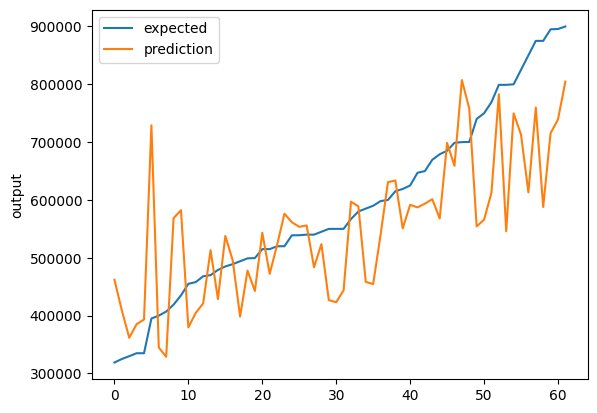

In [80]:
chart_regression(pred_vgg2.flatten(),y_test)

## Transfer Learning : ResNet50

In [87]:
from keras.applications import ResNet50
from keras.layers import Input, Dense, Flatten, Conv2D, Dropout, concatenate, MaxPooling2D
from keras.models import Model
from keras.optimizers import Adam, SGD
from keras.callbacks import ModelCheckpoint, EarlyStopping
import numpy as np
from sklearn import metrics

filepath = './dnn/best_weights-resNet1.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True) 

adam_optimizer = Adam(learning_rate=0.009, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=0.005, momentum=0.9, nesterov=True)

monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')

resNet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 

# Freeze the ResNet layers
for layer in resNet.layers:
    layer.trainable = False
    
conv_layer = Conv2D(128, kernel_size=4, activation='relu')(resNet.output)  
# max_pool = MaxPooling2D(pool_size=(2,2))(conv_layer)
# res_out = Flatten()(max_pool)

flatten_res = Flatten()(conv_layer) 

# Tabular data input (dense layers)
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(512, activation='relu')(visible2) 
dense2 = Dense(1024, activation='relu')(dense1)
# dense2 = Dropout(0.5)(dense2)
dense3 = Dense(1024, activation='relu')(dense2)

merge = concatenate([flatten_res, dense3])


hidden1 = Dense(2048, activation='relu')(merge)
# hidden1 = Dropout(0.5)(hidden1)  
hidden2 = Dense(1024, activation='relu')(hidden1)
hidden2 = Dense(1024, activation='relu')(hidden2)
# hidden2 = Dropout(0.5)(hidden2)  
hidden3 = Dense(512, activation='relu')(hidden2)

output = Dense(1)(hidden3)
# output = Dense(1)(merge) 

model = Model(inputs=[resNet.input, visible2], outputs=output)
model.compile(optimizer=adam_optimizer, loss='mean_squared_error')
model.fit([x_train_img, x_train], y_train, 
          validation_data=([x_test_img, x_test], y_test), 
          callbacks=[monitor, checkpointer], verbose=2, epochs=100)

print('Training finished...Loading the best model')
model.load_weights(filepath) 

pred_resNet = model.predict([x_test_img, x_test])
score_resNet = np.sqrt(metrics.mean_squared_error(pred_resNet, y_test))
print("Score (RMSE): {}".format(score_resNet))

Epoch 1/100
8/8 - 20s - 3s/step - loss: 343688642560.0000 - val_loss: 368869212160.0000
Epoch 2/100
8/8 - 2s - 208ms/step - loss: 355331997696.0000 - val_loss: 357225103360.0000
Epoch 3/100
8/8 - 2s - 196ms/step - loss: 217283854336.0000 - val_loss: 35435380736.0000
Epoch 4/100
8/8 - 4s - 461ms/step - loss: 81378050048.0000 - val_loss: 34845188096.0000
Epoch 5/100
8/8 - 0s - 60ms/step - loss: 39354314752.0000 - val_loss: 39310811136.0000
Epoch 6/100
8/8 - 2s - 216ms/step - loss: 24057284608.0000 - val_loss: 26119258112.0000
Epoch 7/100
8/8 - 0s - 43ms/step - loss: 18042099712.0000 - val_loss: 27164329984.0000
Epoch 8/100
8/8 - 2s - 242ms/step - loss: 16030982144.0000 - val_loss: 22946465792.0000
Epoch 9/100
8/8 - 2s - 194ms/step - loss: 14523408384.0000 - val_loss: 20112242688.0000
Epoch 10/100
8/8 - 2s - 197ms/step - loss: 11718484992.0000 - val_loss: 17581297664.0000
Epoch 11/100
8/8 - 3s - 369ms/step - loss: 11536602112.0000 - val_loss: 16853346304.0000
Epoch 12/100
8/8 - 2s - 205ms

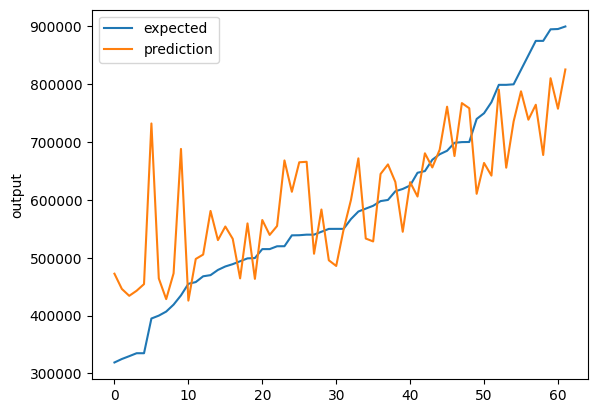

In [64]:
chart_regression(pred_resNet.flatten(),y_test)

## Transfer Learning : ResNet50 #2

In [83]:
# Transfer learning
from keras.applications import ResNet50

filepath = './dnn/best_weights-resNet2.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True)

for i in range(0,5): 
    print("======================================= " , i)
    adam_optimizer = Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
    sgd_optimizer = SGD(learning_rate=1e-4 , momentum=0.9, nesterov=True)
    monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')
    
    resNet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 

    for layer in resNet.layers:
        layer.trainable = False

    conv_layer = Conv2D(128, kernel_size=4, activation='relu')(resNet.output)  
    flatten_res = Flatten()(conv_layer)  


    visible1 = resNet.input

    # Tabular data input model
    visible2 = Input(shape=(x.shape[1],))
    dense1 = Dense(512, activation='relu')(visible2)
    dense2 = Dense(1024, activation='relu')(dense1)
    dense3 = Dense(2048, activation='relu')(dense2)
    dense4 = Dense(512, activation='relu')(dense3)

    merge = concatenate([flatten_res, dense4])

    hidden1 = Dense(512, activation='relu')(merge)
    hidden2 = Dense(1024, activation='relu')(hidden1)
    hidden3 = Dense(2048, activation='relu')(hidden2)
    hidden4 = Dense(2048, activation='relu')(hidden3)
    hidden5 = Dense(512, activation='relu')(hidden4)
    output = Dense(1)(hidden5)

    model = Model(inputs=[visible1, visible2], outputs=output)

    # print(model.summary())
    model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
    model.fit([x_train_img, x_train], y_train,
              validation_data=([x_test_img, x_test], y_test),
              callbacks=[monitor, checkpointer],verbose=2,epochs=150)

print('Training finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred_resNet2 = model.predict([x_test_img, x_test])
score_resNet2 = np.sqrt(metrics.mean_squared_error(pred_resNet2,y_test))
print("Score (RMSE): {}".format(score_resNet2))

=======================================  0
Epoch 1/150
8/8 - 23s - 3s/step - loss: 319721209856.0000 - val_loss: 370657591296.0000
Epoch 2/150
8/8 - 2s - 238ms/step - loss: 290786541568.0000 - val_loss: 227072081920.0000
Epoch 3/150
8/8 - 4s - 552ms/step - loss: 118001278976.0000 - val_loss: 29021890560.0000
Epoch 4/150
8/8 - 0s - 55ms/step - loss: 61190516736.0000 - val_loss: 52206501888.0000
Epoch 5/150
8/8 - 0s - 45ms/step - loss: 35417866240.0000 - val_loss: 55066161152.0000
Epoch 6/150
8/8 - 2s - 216ms/step - loss: 32365518848.0000 - val_loss: 27514355712.0000
Epoch 7/150
8/8 - 2s - 215ms/step - loss: 21655685120.0000 - val_loss: 22070456320.0000
Epoch 8/150
8/8 - 2s - 218ms/step - loss: 17482160128.0000 - val_loss: 22067984384.0000
Epoch 9/150
8/8 - 5s - 606ms/step - loss: 15329366016.0000 - val_loss: 20180443136.0000
Epoch 10/150
8/8 - 2s - 282ms/step - loss: 13808812032.0000 - val_loss: 17435619328.0000
Epoch 11/150
8/8 - 0s - 57ms/step - loss: 15548213248.0000 - val_loss: 1763

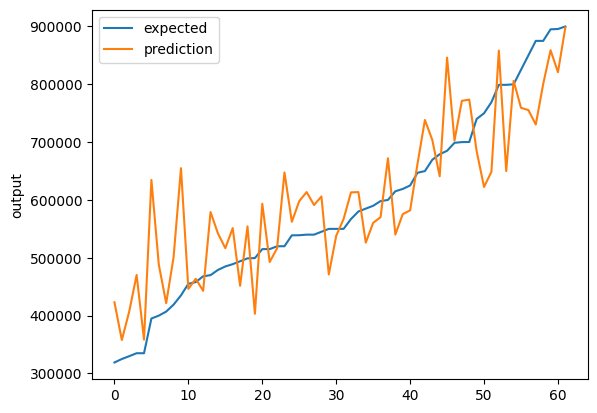

In [84]:
chart_regression(pred_resNet2.flatten(),y_test)

In [85]:
print(model.summary())
plot_model(model, show_shapes=True)

Model: "functional_66"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_67      │ (None, 128, 128,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 134, 134,  │          0 │ input_layer_67[0… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 64, 64,    │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 64, 64,    │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 64, 64,    │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 66, 66,    │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 32, 32,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 32, 32,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 32, 32,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 32, 32,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 32, 32,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 32, 32,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 32, 32,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 32, 32,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 32, 32,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 32, 32,    │      1,024 │ conv2_block1_3_c

 Total params: 71,843,077 (274.06 MB)

 Trainable params: 16,085,121 (61.36 MB)

 Non-trainable params: 23,587,712 (89.98 MB)

 Optimizer params: 32,170,244 (122.72 MB)

None


## Transfer Learning : ResNet #3

In [100]:
adam_optimizer = Adam(learning_rate=0.0075, beta_1=0.9, beta_2=0.999, epsilon=1e-07)
sgd_optimizer = SGD(learning_rate=1e-4 , momentum=0.9, nesterov=True)

filepath = './dnn/best_weights-resNet3.keras'
checkpointer = ModelCheckpoint(filepath=filepath, verbose=0, save_best_only=True)
monitor = EarlyStopping(monitor='val_loss', min_delta=1e-3, patience=25, verbose=1, mode='auto')
    
resNet = ResNet50(weights='imagenet', include_top=False, input_shape=(128, 128, 3)) 

for layer in resNet.layers:
    layer.trainable = True

conv_layer = Conv2D(128, kernel_size=4, activation='relu')(resNet.output)  
flatten_res = Flatten()(conv_layer)  


visible1 = resNet.input

# Tabular data input model
visible2 = Input(shape=(x.shape[1],))
dense1 = Dense(512, activation='relu')(visible2)
dense2 = Dense(1024, activation='relu')(dense1)
dense3 = Dense(2048, activation='relu')(dense2)
# dense3 = Dropout(0.1)(dense3)
dense4 = Dense(512, activation='relu')(dense3)

merge = concatenate([flatten_res, dense4])

hidden1 = Dense(512, activation='relu')(merge)
hidden2 = Dense(1024, activation='relu')(hidden1)
hidden3 = Dense(2048, activation='relu')(hidden2)
# hidden3 = Dropout(0.2)(hidden3)
hidden4 = Dense(2048, activation='relu')(hidden3)
hidden5 = Dense(512, activation='relu')(hidden4)
output = Dense(1)(hidden5)

model = Model(inputs=[visible1, visible2], outputs=output)

# print(model.summary())
model.compile(loss='mean_squared_error', optimizer=adam_optimizer)
model.fit([x_train_img, x_train], y_train,
            validation_data=([x_test_img, x_test], y_test),
            callbacks=[monitor, checkpointer],verbose=2,epochs=150)

print('Training finished...Loading the best model')
print()
model.load_weights(filepath) # load weights from best model

pred_resNet3 = model.predict([x_test_img, x_test])
score_resNet3 = np.sqrt(metrics.mean_squared_error(pred_resNet3,y_test))
print("Score (RMSE): {}".format(score_resNet3))

Epoch 1/150
8/8 - 81s - 10s/step - loss: 21457895686144.0000 - val_loss: inf
Epoch 2/150
8/8 - 1s - 129ms/step - loss: 334170357760.0000 - val_loss: inf
Epoch 3/150
8/8 - 1s - 116ms/step - loss: 207081947136.0000 - val_loss: inf
Epoch 4/150
8/8 - 3s - 409ms/step - loss: 168297611264.0000 - val_loss: 9808948503951855215782212646469632.0000
Epoch 5/150
8/8 - 5s - 590ms/step - loss: 110809612288.0000 - val_loss: 11863660548948005796769840496640.0000
Epoch 6/150
8/8 - 4s - 542ms/step - loss: 91185160192.0000 - val_loss: 52509409632972446024649932800.0000
Epoch 7/150
8/8 - 3s - 427ms/step - loss: 51178123264.0000 - val_loss: 510849004047171880621178880.0000
Epoch 8/150
8/8 - 3s - 426ms/step - loss: 27910414336.0000 - val_loss: 7019695166771817600778240.0000
Epoch 9/150
8/8 - 4s - 501ms/step - loss: 21446799360.0000 - val_loss: 192468013417525164376064.0000
Epoch 10/150
8/8 - 3s - 419ms/step - loss: 13124233216.0000 - val_loss: 4390464982606298480640.0000
Epoch 11/150
8/8 - 4s - 467ms/step -